## Plotting optimal SNR as a function of time-before-merger for mock signals

In [1]:
import numpy as np
import json

%matplotlib inline
from matplotlib import pyplot as plt

from glob import glob
plt.style.use('../../paper.mplstyle')

In [2]:
search_result_files = glob('../search_run_*.json')
plot_ifar_limit = 100

In [3]:
# Define some things for style of the plots
psd_styles = {
    'CUT_optimistic':':',
    'cutoff':':',
    'pessimistic':'--',
    'optimistic':'-',
}
psd_style_markers = {
    'cutoff':'x',
    'CUT_optimistic': 'x',
    'pessimistic':'v',
    'optimistic':'^',
}
search_times_before = [0.5,1,4,7,14]

In [4]:
# Make the figure - 1.5 times the normal height so we can see detail
width = plt.rcParams["figure.figsize"][0]
height = plt.rcParams["figure.figsize"][1] * 1.5
inj_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

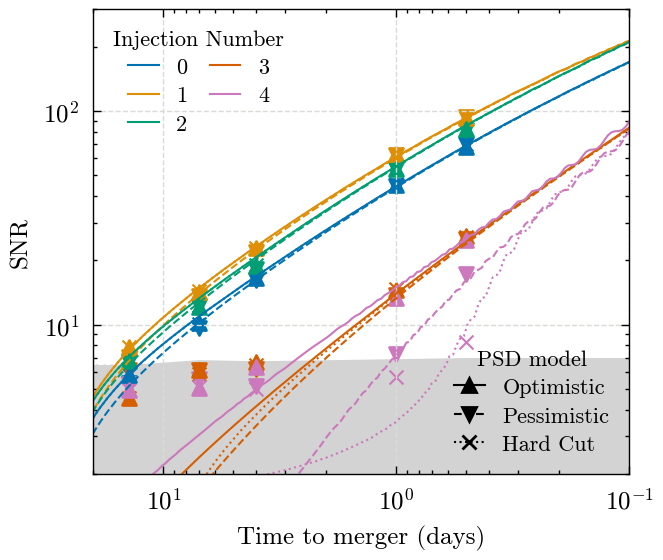

In [5]:
fig, ax = plt.subplots(
    1, figsize=(width, height),
)

search_results_all = {}
for srf in search_result_files:
    with open(srf) as srfp:
        search_results = json.load(srfp)
    search_results_all[search_results['psd_type']] = search_results
    for inj_no in range(5):
        ax.scatter(
            search_times_before,
            search_results[str(inj_no)]['snr'],
            marker=psd_style_markers[search_results['psd_type']],
            color=inj_colors[inj_no]
        )
        times = search_results[str(inj_no)]['optimal_snr_all_time']
        snrs = search_results[str(inj_no)]['optimal_snr_all']
        ax.plot(
            times,
            snrs,
            color=inj_colors[inj_no],
            linestyle=psd_styles[search_results['psd_type']]
        )

inj_lines = []
inj_labels = []
for inj_no in range(5):
    inj_lines += [ax.plot([],[], color=inj_colors[inj_no])[0]]
    inj_labels.append(f'{inj_no}')

leg1 = ax.legend(
    inj_lines,
    inj_labels,
    loc='upper left',
    title='Injection Number',
    ncol=2,
)

psd_lines = [
    ax.plot(
        [],
        [],
        linestyle=psd_styles[psd_type],
        marker=psd_style_markers[psd_type],
        color='k'
    )[0]
    for psd_type in ['optimistic', 'pessimistic', 'CUT_optimistic']
]
psd_labels = ['Optimistic', 'Pessimistic', 'Hard Cut']
leg2 = ax.legend(
    psd_lines,
    psd_labels,
    loc='lower right',
    title='PSD model'
)
ax.add_artist(leg1)

# these may not be the same for all psds
# (close but no cigar)
for psd in ['cutoff', 'pessimistic', 'optimistic']:
    search_results = search_results_all[psd]
    fit_coeffs = search_results['alpha']
    fit_thresh = search_results['fit_threshold']
    rate_above = search_results['rate_above']
    # To convert an IFAR limit to an SNR, we invert the formula for
    # the exponential fit
    snr_lim = [
        t + np.log(plot_ifar_limit * r) / a
        for a, r, t in zip(fit_coeffs, rate_above, fit_thresh)
    ]
    ax.fill_between(
        [0] + search_times_before + [1e3],
        np.zeros(len(search_times_before)+2),
        [snr_lim[0]] + snr_lim + [snr_lim[-1]],
        linestyle=psd_styles[psd],
        color='lightgray',
        zorder=-100
    )
ax.loglog()
ax.grid(zorder=-30)
ax.set_ylim(bottom=2, top=300)
ax.set_xlim([0.1, 20])
ax.set_xlabel('Time to merger (days)')
ax.set_ylabel('SNR')
ax.invert_xaxis()